

# 1. Setup

1.1 Importing Libraries

In [1]:
import cv2 
import os 
import random 
import numpy as np 
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# model(inputs=[inputimage, verificationimage], outputs=[0,1])
# class L1Dist(Layer) custom nerual network layer
# input(shape=)

1.2 Set GPU Growth

In [5]:
# avoids out of memory errors, by setting GPU memory consumption growth
# grabs all gpu's
gpus = tf.config.experimental.list_physical_devices("GPU")
# goes through each gpu, setting memory growth to true
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1.3 Create Folder Structures

In [9]:
POS_PATH = os.path.abspath("..\data\\positive")
NEG_PATH = os.path.abspath("..\data\\negative")
ANC_PATH = os.path.abspath("..\data\\anchor")

In [ ]:
# make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. COLLECT POSITIVES AND ANCHORS
take webcam input (the anchor) and positive image (passport image), then encode them using a model encoding. Once done the distance layer will show how similar they are to each other and output 1 or 0. 
we then want to do the same but with the anchor and a negative image. The model encoding is going to be the same throughout both a positive and negative image.
the negative faces will come from Labelled faces in the wild dataset.

2.1 Untar Labelled Faces in the Wild Dataset

In [10]:
# http://vis-www.cs.umass.edu/lfw/

In [17]:
# uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf "..\lfw.tgz"

In [18]:
# move LFW Images to the following repository data/negative
for directory in os.listdir("lfw"):
    for file in os.listdir(os.path.join("lfw", directory)):
        EX_PATH = os.path.join("lfw", directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)
    

2.2 Collect Postitive and Anchor Classes
we want all images 250x250 as all of our negatives are that size

In [19]:
# import uuid (universally unique identifiers) library to generate unique image name 
import uuid

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'): # quits when q is pressed
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

3.1 Get Image Directories

In [20]:
# loads all the files in each of the directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300) 
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

3.2 Preprocessing - Scale and Resize

In [21]:
# changes image to numbers
def preprocess(file_path):
    # reading img
    byte_img = tf.io.read_file(file_path)
    # using tf decode image to load it in
    img = tf.io.decode_jpeg(byte_img)
    # resizes img
    img = tf.image.resize(img, (100,100))
    # scales image to be between 0 and 1
    img = img / 255.0
    return img

3.3 Create Labelled Dataset

In [22]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

# first we are combining the anchor images and the postitives together. Then we add a 1.0 at the end to show it's a match
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
# we are doing something similar here, but combining the anchor and negative images together instead. Then we add a 0.0 at the end to show that they do not match
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
# concatenated them together so that we can work with them
data = positives.concatenate(negatives)


In [23]:
sample = data.as_numpy_iterator()

In [24]:
example =sample.next()

3.4 Build Train and Test Partition

In [25]:
# we want to be able to put all of these images and labels in the list, so the list will look like, [input_image, validation_img, label] Each dataset will have this 
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

1.0

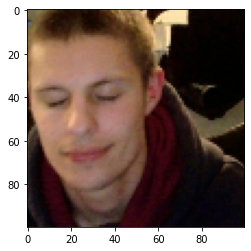

In [26]:
# *example unpacks all of the example images, then passes them through to preprocess_twin
res = preprocess_twin(*example)
len(res) 

plt.imshow(res[1])
res[2]

In [27]:
#### build dataLoader pipeline ####

# runs our preprocess_twin function on our data (contains the input_img and validation_img), and maps the data
data = data.map(preprocess_twin)
# caching our images so we can access them faster
data = data.cache()
# shuffles all our data
data = data.shuffle(buffer_size=1024)

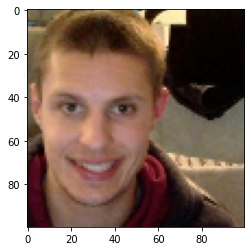

In [28]:
samples = data.as_numpy_iterator()
sample = samples.next()
# anchor image
plt.imshow(sample[0])


1.0


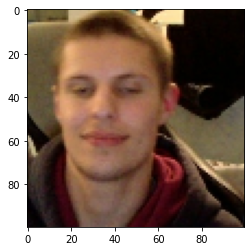

In [29]:
# negative or positive img
plt.imshow(sample[1])
# shows us the label (if it's a match or not)
print(sample[2])

In [30]:
#### training partition ####

# takes 70% of images for training data
train_data = data.take(round(len(data)*.7))
# changes our data to batches of 16
train_data = train_data.batch(16)
# starts preprocessing the next set of images so that we don't bottle neck our next set images
train_data = train_data.prefetch(8)

In [31]:
# now in the first index of our data we have 16 images
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
len(train_sample[0])

16

In [32]:
#### testing partition ####

# skipped first 70% of images which we used in train data
test_data = data.skip(round(len(data)*.7))
# then takes the rest of the 30% of data for testing
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

4.1 Build Embedding Layer

In [33]:
def make_embedding():
    input = Input(shape=(100,100,3), name="input_image")

    #### First block ####
    # convolution takes in number of filters we want to pass through, and the filter shape e.g 10x10
    c1 = Conv2D(64, (10,10), activation="relu")(input)
    # we again want 64, with the shape of 2x2, which condences down the amount of data. Padding=same replicates a similar output shape 
    m1 = MaxPooling2D(64, (2,2), padding="same")(c1)

    #### Second Block ####
    c2 = Conv2D(128, (7,7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2,2), padding="same")(c2)

    #### Third Block ####
    c3 = Conv2D(128, (4,4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2,2), padding="same")(c3)

    #### Final Embedding Block ####
    c4 = Conv2D(256, (4,4), activation="relu")(m3)
    # takes all the outputs of our convolution layer (which is 3d) and flattens it to 2d
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)

    # model class comes from the TensorFlow library, it will compile all our layers into a model
    # it will ensure it takes our input, then goes through all our layers, and give it the name of embedding
    return Model(inputs=[input], outputs=[d1], name="embedding")

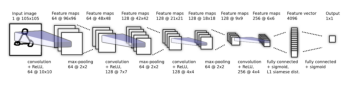

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image2 = mpimg.imread("deep_learning.png")
plt.imshow(image2)
plt.axis('off')  # Hide axes
plt.show()

In [38]:

# this changes the input image down to the feature maps, as seen in the deep_learning screenshot. The shape has now changed after being passed through the convolution layer and now is in the max_pooling layer
input = Input(shape=(100,100,3), name="input_image")

c1 = Conv2D(64, (10,10), activation="relu")(input)
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d_1')>

In [39]:
# again has taken the image down to the next layer
m1 = MaxPooling2D(64, (2,2), padding="same")(c1)
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [40]:
#### Second Block ####
c2 = Conv2D(128, (7,7), activation="relu")(m1)
m2 = MaxPooling2D(64, (2,2), padding="same")(c2)

#### Third Block ####
c3 = Conv2D(128, (4,4), activation="relu")(m2)
m3 = MaxPooling2D(64, (2,2), padding="same")(c3)

c4 = Conv2D(256, (4,4), activation="relu")(m3)
# takes all the outputs of our convolution layer (which is 3d) and flattens it to 2d
f1 = Flatten()(c4)
d1 = Dense(4096, activation="sigmoid")(f1)


In [41]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_4')>

In [42]:
6*6*256

9216

In [43]:
# took our data to flatten all 9216 units of data into a single dimension
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

In [44]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [45]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 17, 128)       26

4.2 Build Distance Layer

In [46]:
class L1Dist(Layer):
    # **kwargs allows you to work with this specific layer as a part of the bigger model.
    def __init__(self, **kwargs):
        # performs inheritance on the function
        super().__init__()

    # calls tells the layer what to do when some data is passed through it
    # our two inputs are now going to combine
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

4.3 Make Siamese Model

In [47]:
def make_siamese_model():
    ## defines our two inputs
    # anchor image
    input_image = Input(name="input_img", shape=(100,100,3))
    # validation image
    validation_image = Input(name="validation_img", shape=(100,100,3))

    # Combines siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation="sigmoid")(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")
    

In [48]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

5.1 Setup Loss and Optimiser

In [49]:
# the loss will be used later to be able to calculate our loss (1 or 0)
binary_loss = tf.losses.BinaryCrossentropy()

In [50]:
# improves speed and performance
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

5.2 Establish Checkpoints

In [51]:
# if something goes wrong we can go back 
# defined our checkpoint dir
checkpoint_dir = "./training_checkpoints"
# makes sure that all our checkpoints have the prefix of ckpt (stands for checkpoint)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# defined our checkpoint class
# esentially saves our the model and optimiser at the time we run the checkpoint class
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


5.3 Build Train Step Function

In [52]:
# What happens when we train on a single batchfunction

In [53]:
# compiles our function into a callable TensorFlow graph
@tf.function
def train_step(batch):
    # allows us to capture our gradient from the model, records the operations for automatic differentiation
    # in short tape will record data, so that when we call it, we can take the data from the whole model
    # records all of our operations
    with tf.GradientTape() as tape:
        # get anchor and positive/negative images
        # remember when we defined our train data, we had a list containing [anchor, positive/negative, label]
        x = batch[:2]
        # gets the label
        y = batch[2]

        # forward pass
        # passes our data through the siamese model to make a prediction
        y_pred = siamese_model(x, training=True)
        # calculate loss
        # to calculate our loss we first pass through our y true value, so our label. Then we pass through our predicted value
        # the smaller the loss the closer our prediction is to the true labels (y_pred). 
        loss = binary_loss(y, y_pred)
    

        # calculate gradients
        # calculates all of the gradients in respect to our loss for all of our trainable variables
        # calculates all the graidients for our different wieghts within our specific model in respect to our loss
        grad = tape.gradient(loss, siamese_model.trainable_variables)

        # calculate updated weights and apply to siamese model
        # the optimiser is calculating and propagating the new weights using Adam's optimisation algorithm, a variant of gradient desecent
        # applying our learning rate and slightly reducing the loss by changing the weights to be closer to the optimiser.
        # 
        opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

5.4 Build Training Loop

In [54]:
def train(data, EPOCHS):
    # loop through the EPOCHS
    for epoch in range(1, EPOCHS + 1):
        print(f"\n Epoch {epoch}/{EPOCHS}")
        progress_bar = tf.keras.utils.Progbar(len(data))
        
        # loop through each batch
        for index, batch in enumerate(data):
            # applying our train step function to a single batch
            train_step(batch)
            # updating our progress bar
            progress_bar.update(index + 1)

        # save checkpoint every 10 epochs
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)


5.5 Train the Model

In [55]:
EPOCHS = 100
train(train_data, EPOCHS)


 Epoch 1/100
27/27 [==============================] - 16s 378ms/step

 Epoch 2/100
27/27 [==============================] - 9s 364ms/step

 Epoch 3/100
27/27 [==============================] - 9s 361ms/step

 Epoch 4/100
27/27 [==============================] - 10s 362ms/step

 Epoch 5/100
27/27 [==============================] - 10s 363ms/step

 Epoch 6/100
27/27 [==============================] - 10s 363ms/step

 Epoch 7/100
27/27 [==============================] - 10s 362ms/step

 Epoch 8/100
27/27 [==============================] - 9s 361ms/step

 Epoch 9/100
27/27 [==============================] - 10s 362ms/step

 Epoch 10/100
27/27 [==============================] - 10s 362ms/step

 Epoch 11/100
27/27 [==============================] - 9s 363ms/step

 Epoch 12/100
27/27 [==============================] - 9s 356ms/step

 Epoch 13/100
27/27 [==============================] - 9s 352ms/step

 Epoch 14/100
27/27 [==============================] - 9s 353ms/step

 Epoch 15/100
27/27 [

# 6. Evaluate Model

6.1 Import metrics

In [56]:
# Precision: Computes the precision of the predictions with respect to the labels
# Recall: Computes the recall of the predictions with respect to the labels
# higher the number the better
# Precision demonstrates what proportion of positive identifications were actually correct
# Recall shows what proportion of actual positives were identified correctly
from tensorflow.keras.metrics import Precision, Recall


6.2 Make predictions

In [57]:
# get a batch of test data
# unpacks the data of each (test_input = input image, test_val = validation_image, y_true = labels)
test_input, test_validation, y_true = test_data.as_numpy_iterator().next() # converts our dataset as a numpy equivalent


In [58]:
# takes our test_data batch and turns into numpy. The .next gets the next batch of data looping through them all
test_var = test_data.as_numpy_iterator().next()

In [59]:
# len is 3 as input_image, positive/negative image, label
print(len(test_var))
# index 0 will be our input image
print("\n",test_var[0])
# as you can see the input images are in batches of 16
print("\n",len(test_var[0]))

3

 [[[[0.48578432 0.45367646 0.2992647 ]
   [0.4852941  0.46200982 0.3262255 ]
   [0.4715686  0.4504902  0.34411764]
   ...
   [0.07769608 0.04044118 0.02377451]
   [0.07647059 0.03333334 0.0254902 ]
   [0.06960785 0.03039216 0.02254902]]

  [[0.5061275  0.4610294  0.2855392 ]
   [0.4897059  0.44411764 0.29068628]
   [0.46887255 0.43333334 0.30392158]
   ...
   [0.0629902  0.03357843 0.01102941]
   [0.0625     0.02426471 0.01348039]
   [0.05686275 0.01764706 0.00980392]]

  [[0.48406863 0.44019607 0.29681373]
   [0.47083333 0.4362745  0.2887255 ]
   [0.44705883 0.4151961  0.2740196 ]
   ...
   [0.06715687 0.03333334 0.0129902 ]
   [0.07230392 0.03406863 0.02328431]
   [0.05759804 0.02426471 0.01348039]]

  ...

  [[0.10808823 0.05465686 0.06862745]
   [0.13137256 0.025      0.06348039]
   [0.19681373 0.02132353 0.08308823]
   ...
   [0.4595588  0.389951   0.2884804 ]
   [0.4495098  0.3718137  0.2754902 ]
   [0.46568626 0.38235295 0.29803923]]

  [[0.06421569 0.02965686 0.04926471]
   

In [60]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [64]:
#model.predict([test_input, test_validation])

input2_img = preprocess(os.path.abspath("..\\application\\application_data\input_image\input_img.jpg"))
verification2_img = preprocess(os.path.abspath("..\\application\\application_data\\verification_images\\passport_img.jpg"))
# Add a batch dimension to a single image tensor
input2_img = tf.expand_dims(input2_img, axis=0)
print(input2_img.shape)  # e.g. (1, height, width, channels)

input2_img = tf.reshape(input2_img, [1, 100, 100, 3])
print(test_input.shape)
print(input2_img.shape)
#siamese_model.predict([input_img, verification_img])

(1, 100, 100, 3)
(16, 100, 100, 3)
(1, 100, 100, 3)


In [65]:
# make predictions
print(test_var[2])
#print(test_var[1])
print(test_validation)
y_pred = siamese_model.predict([test_input, test_validation])
y_pred

[0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.]
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  ...

  [[0.00000000e+

array([[1.3553583e-05],
       [4.5764487e-08],
       [1.0000000e+00],
       [4.8743481e-11],
       [1.0000000e+00],
       [9.3148724e-09],
       [2.1888477e-06],
       [1.0000000e+00],
       [4.6801282e-11],
       [7.1866248e-06],
       [9.9999940e-01],
       [3.0891956e-11],
       [2.8243940e-07],
       [8.7488224e-06],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [66]:
# post-processing the results
# if prediction is > 0.5, we want our result to add a 1
results = []
for prediction in y_pred:
    if prediction > 0.5:
        results.append(1)
    else:
        results.append(0)
results

[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1]

In [67]:
y_true

array([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.],
      dtype=float32)

6.3 Calculating metrics

In [68]:
#### Compares the two pieces of data rather than looking at the two lists above
# creating a metric object
m = Recall()
# calculating the recall value
m.update_state(y_true, y_pred)
# returns the result
m = m.result().numpy()
m


1.0

In [69]:
m = Precision()
# calculating the recall value
m.update_state(y_true, y_pred)
# returns the result
m = m.result().numpy()
m

1.0

6.4 Visualise results

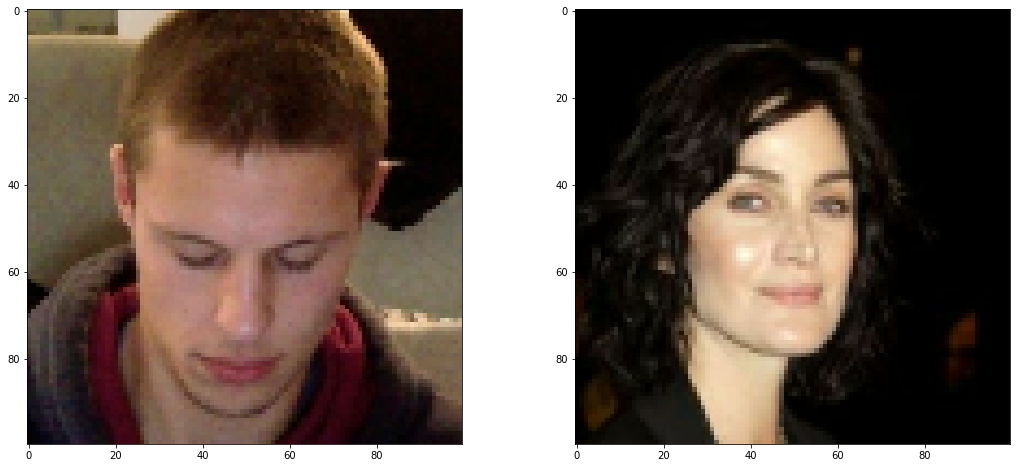

In [70]:
# can change array values to values in prediction to show predicted values are right
# figsize sets how big our plot is
plt.figure(figsize=(18,8))
# we are setting two images side by side
# the subplot function allows you to render plots using a grid like format. First number is rows, second  the columns, third the index (this image has 1, so our first image)
# so we've set two 1 row, and 2 columns, with the first image being first
plt.subplot(1,2,1)
plt.imshow(test_input[0])
# second image index number is 2 meaning it will be placed after the first, next to it as there is only one row
plt.subplot(1,2,2)
plt.imshow(test_validation[0])

# 7. Save Model

In [77]:
siamese_model.compile(optimizer=opt, loss=binary_loss, metrics=['accuracy']) 

In [78]:
# because we created a custom layer, we're going to need to change it a bit so we can export it all
# h5 means our model weight
siamese_model.save("../siamese_model.h5")

In [80]:
# reloads model
# first loads the file
#3.36.57 time for help when importing
# We're first passing through to our custom objects our L1Dist layer, then we want to pass through our BinaryCrossentropy, because we created a seperate key for
# the custom objects is creating a dictionary of name:class
L1Dist
model = tf.keras.models.load_model("../siamese_model.h5", custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy":tf.losses.BinaryCrossentropy})

In [81]:
# make predictions with reloaded model

input_img = preprocess(os.path.abspath("..\\application\\application_data\input_image\input_img.jpg"))
verification_img = preprocess(os.path.abspath("..\\application\\application_data\\verification_images\\passport_img.jpg"))

input_img = tf.expand_dims(input2_img, axis=0)
verification_img = tf.expand_dims(verification_img, axis=0)

input_img = tf.reshape(input2_img, [1, 100, 100, 3])

siamese_model.predict([input_img, verification_img])

1/1 [==============================] - 0s 89ms/step


array([[0.4098493]], dtype=float32)